# <a id='toc1_'></a>[Поиск паттернов в многомерных временных рядах для предотвращения отказов в технологическом оборудовании](#toc0_)

Задача состоит в поиске паттернов, предшествующих отказу технологического оборудования. Задача относится к классификации многомерных временных рядов.

В качестве данных используются показания с датчиков температуры подшипников компрессора за 2 года.

**Table of contents**<a id='toc0_'></a>    
- [Поиск паттернов в многомерных временных рядах для предотвращения отказов в технологическом оборудовании](#toc1_)    
- [1 EDA](#toc2_)    
- [2 Preprocessing](#toc3_)    
- [3 Modelling](#toc4_)    
  - [tsfresf + CatBoost](#toc4_1_)    
  - [CNN](#toc4_2_)    
    - [CNN](#toc4_2_1_)    
    - [CNN на смещенном паттерне](#toc4_2_2_)    
    - [CNN с масштабированием каждого окна](#toc4_2_3_)    
  - [Vanilla Transformer](#toc4_3_)    
    - [С масштабированием всей выборки](#toc4_3_1_)    
    - [С масштабированием каждого окна](#toc4_3_2_)    
  - [CNN + Transformer](#toc4_4_)    
    - [С масштабированием всей выборки](#toc4_4_1_)    
    - [CNN + Transformer с масштабированием каждого окна](#toc4_4_2_)    
  - [Informer](#toc4_5_)    
    - [С масштабированием всей выборки](#toc4_5_1_)    
    - [Informer с масштабированием каждого окна](#toc4_5_2_)    
  - [iTransformer](#toc4_6_)    
    - [С масштабированием всей выборки](#toc4_6_1_)    
    - [С масштабированием каждого окна](#toc4_6_2_)    
- [4 Выводы](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [8]:
import pandas as pd
import numpy as np

from seaborn import heatmap
from sklearn.preprocessing import StandardScaler

import plotly
import plotly.graph_objs as go
from   plotly.subplots import make_subplots

from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
from catboost import CatBoostClassifier

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.settings import MinimalFCParameters

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings('ignore')

In [ ]:
X = pd.read_csv('Компрессор/X.csv', parse_dates=True, index_col=0)

# <a id='toc2_'></a>[1 EDA](#toc0_)

In [3]:
display(X.head())
display(X.tail())

,0,1,2,3,4,5,6,7,8,9,10,11
datetime,,,,,,,,,,,,
2022-01-01 00:00:00,39.366243,39.042265,38.878460,38.814402,84.992254,84.822547,85.748036,86.139467,84.896086,85.096198,85.219893,85.124333
2022-01-01 00:10:00,39.306476,39.322175,38.834323,39.124901,84.978888,84.764294,85.768047,86.228679,85.133108,85.445578,85.176276,85.435617
2022-01-01 00:20:00,39.301215,39.319921,38.835075,39.130163,84.987167,84.765807,86.114947,86.226437,85.090743,85.414732,85.177789,85.438617
2022-01-01 00:30:00,39.205322,39.284548,38.848006,39.227044,85.145350,84.806108,85.970018,86.184978,84.291436,84.826922,85.214580,85.492154
2022-01-01 00:40:00,39.355293,39.518925,38.804020,39.108708,85.145861,85.099827,85.999919,86.258341,84.306880,84.882241,85.421010,85.359492


,0,1,2,3,4,5,6,7,8,9,10,11
datetime,,,,,,,,,,,,
2023-11-19 23:10:00,22.295343,21.577818,21.596045,21.799421,48.395706,48.54356,46.96782,47.04134,47.358223,47.698696,47.689053,47.919636
2023-11-19 23:20:00,22.295343,21.577818,21.596045,21.799421,48.395706,48.54356,46.96782,47.04134,47.358223,47.698696,47.689053,47.919636
2023-11-19 23:30:00,22.295343,21.577818,21.596045,21.799421,48.395706,48.54356,46.96782,47.04134,47.358223,47.698696,47.689053,47.919636
2023-11-19 23:40:00,22.295343,21.577818,21.596045,21.799421,48.395706,48.54356,46.96782,47.04134,47.358223,47.698696,47.689053,47.919636
2023-11-19 23:50:00,22.295343,21.577818,21.596045,21.799421,48.395706,48.54356,46.96782,47.04134,47.358223,47.698696,47.689053,47.919636


In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 99072 entries, 2022-01-01 00:00:00 to 2023-11-19 23:50:00
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       99072 non-null  float64
 1   1       99072 non-null  float64
 2   2       99072 non-null  float64
 3   3       99072 non-null  float64
 4   4       99072 non-null  float64
 5   5       99072 non-null  float64
 6   6       99072 non-null  float64
 7   7       99072 non-null  float64
 8   8       99072 non-null  float64
 9   9       99072 non-null  float64
 10  10      99072 non-null  float64
 11  11      99072 non-null  float64
dtypes: float64(12)
memory usage: 9.8 MB


Пропусков нет.

Дубликатов нет.

Данные упорядочены.

12 столбцов - температура подшипников.

Данные ресемплированы по 10 мин.

Данные взяты за период 2022-01-01 00:00:00 - 2023-11-19 23:50:00.

In [5]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,99072.000000,99072.000000,99072.000000,99072.000000,99072.000000,99072.000000,99072.000000,99072.000000,99072.000000,99072.000000,99072.000000,99072.000000
mean,31.418240,31.428742,31.008759,31.677152,68.972505,68.770263,69.128971,69.287269,68.322175,68.688310,69.540378,69.589454
std,7.734143,7.558409,7.764753,7.998436,24.987407,24.957804,25.072285,25.086779,24.981971,24.979657,25.547969,25.586881
min,0.366222,2.990804,-0.335690,2.838214,4.608231,4.547192,4.730302,4.577709,4.562450,4.776081,5.020223,5.004963
25%,29.541471,29.480434,29.282069,29.465178,74.296180,74.113076,73.167019,73.304345,73.243321,73.624790,72.037840,72.068360
50%,33.600385,33.463042,33.279932,33.630886,79.072263,78.873885,79.087524,79.224846,78.645010,78.980707,79.316402,79.377418
75%,36.667440,36.636918,36.224918,37.277791,82.825987,82.642887,83.710994,83.970385,82.215611,82.658127,84.702834,84.855423
max,64.988114,61.249710,64.789746,61.509090,135.698489,135.133898,128.786150,128.908220,129.274440,129.777980,130.571440,130.556180


<Axes: >

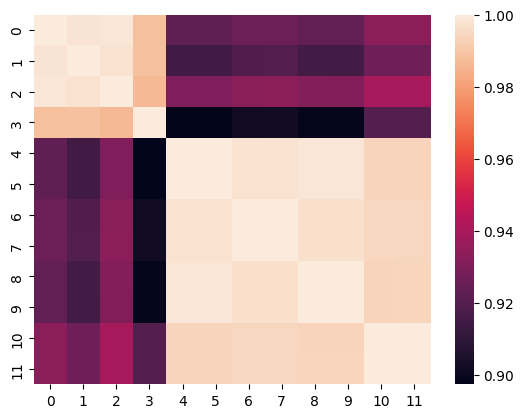

In [6]:
heatmap(X.corr())

Визуализируем данные.

In [7]:
fig = make_subplots(rows=1, cols=1, vertical_spacing=0.1,
                    specs=[[{"secondary_y": True}],], shared_xaxes = True)

for col in X.columns:
        fig.add_trace(go.Scattergl( x = X.index,
                                    y = X[col].values,
                                    mode = 'lines',
                                    name = col,
                                    showlegend =True),
                                    row = 1, col = 1)

plotly.offline.plot(fig, filename = "graphs/data.html",  show_link=False, auto_open=False)

'graphs/data.html'

В данных есть участки, когда оборудование не работало - офлайн-периоды. На этих участках делать расчет нет необходимости.

In [8]:
offline_periods1 = [{'begin': '2022-01-11T20:30', 'end': '2022-01-14T10:10'},
 {'begin': '2022-01-14T10:30', 'end': '2022-01-14T15:10'},
 {'begin': '2022-02-18T13:20', 'end': '2022-02-18T19:50'},
 {'begin': '2022-02-20T07:20', 'end': '2022-02-25T05:10'},
 {'begin': '2022-04-25T09:50', 'end': '2022-04-28T05:20'},
 {'begin': '2022-05-16T05:50', 'end': '2022-05-20T05:30'},
 {'begin': '2022-06-05T01:20', 'end': '2022-06-05T02:30'},
 {'begin': '2022-06-05T04:50', 'end': '2022-06-05T05:30'},
 {'begin': '2022-07-12T06:20', 'end': '2022-07-14T10:00'},
 {'begin': '2022-08-03T07:50', 'end': '2022-08-05T12:00'},
 {'begin': '2022-08-07T21:40', 'end': '2022-08-07T22:40'},
 {'begin': '2022-08-17T03:50', 'end': '2022-08-19T15:40'},
 {'begin': '2022-11-02T07:40', 'end': '2022-11-03T15:00'},
 {'begin': '2022-11-09T20:10', 'end': '2022-11-10T13:50'},
 {'begin': '2022-11-11T11:10', 'end': '2022-11-18T04:50'},
 {'begin': '2022-12-03T08:20', 'end': '2023-01-09T23:00'},
 {'begin': '2023-01-23T05:50', 'end': '2023-02-02T12:20'},
 {'begin': '2023-02-15T05:40', 'end': '2023-02-21T02:40'},
 {'begin': '2023-08-26T00:40', 'end': '2023-08-26T02:20'},
 {'begin': '2023-09-22T08:20', 'end': '2023-09-25T06:00'},
 {'begin': '2023-10-10T18:40', 'end': '2023-10-10T19:00'},
 {'begin': '2023-10-11T06:20', 'end': '2023-10-11T22:40'},
 {'begin': '2023-10-12T04:40', 'end': '2023-11-18T12:30'}]

In [9]:
offline_periods = []

for period1 in offline_periods1:
    period = {'begin': pd.to_datetime(period1['begin']) - pd.Timedelta('3h'),
              'end': pd.to_datetime(period1['end']) - pd.Timedelta('3h')}
    offline_periods.append(period)

In [10]:
X_states = X[[]]

In [11]:
X_states['offline'] = 0
for period in offline_periods:
    X_states.loc[period['begin']:period['end'],'offline'] = 1

Визуализируем офлайн-периоды.

In [12]:
fig = make_subplots(rows=1, cols=1, vertical_spacing=0.1,
                    specs=[[{"secondary_y": True}],], shared_xaxes = True)

for col in X.columns:
        fig.add_trace(go.Scattergl( x = X.index,
                                    y = X[col].values,
                                    mode = 'lines',
                                    name = col,
                                    showlegend =True),
                                    row = 1, col = 1)

fig.add_trace(go.Scattergl(x = X_states.index,
                             y = X_states['offline'].values,
                             name = f'offline',
                             showlegend =True,
                             fill='tozeroy',
                             opacity=0.25,
                             hovertemplate='%{y:.2f}',
                             line={'width':1,'color':'black'},
                            ),
                      secondary_y=True,
                      row = 1, col = 1)

plotly.offline.plot(fig, filename = "graphs/data_offline.html",  show_link=False, auto_open=False)

'graphs/data_offline.html'

Определим участки отказов с одинаковым паттерном - 5 дней до отключения оборудования.

In [13]:
green_failurs = [{'begin': '2022-02-15 07:10:00', 'end': '2022-02-20 04:10:00'},
                 {'begin': '2022-04-20 09:40:00', 'end': '2022-04-25 06:40:00'},
                 {'begin': '2022-08-12 03:40:00', 'end': '2022-08-17 00:40:00'},
                 {'begin': '2023-09-17 08:10:00', 'end': '2023-09-22 05:10:00'}]

In [14]:
X_states['green_failurs'] = 0
for period in green_failurs:
    X_states.loc[period['begin']:period['end'],'green_failurs'] = 1

Визуализируем размеченные участки отказов.

In [ ]:
fig = make_subplots(rows=1, cols=1, vertical_spacing=0.1,
                    specs=[[{"secondary_y": True}],], shared_xaxes = True)

for col in X.columns:
        fig.add_trace(go.Scattergl( x = X.index,
                                    y = X[col].values,
                                    mode = 'lines',
                                    name = col,
                                    showlegend =True),
                                    row = 1, col = 1)

fig.add_trace(go.Scattergl(x = X_states.index,
                             y = X_states['offline'].values,
                             name = f'offline',
                             showlegend =True,
                             fill='tozeroy',
                             opacity=0.25,
                             hovertemplate='%{y:.2f}',
                             line={'width':1,'color':'black'},
                            ),
                      secondary_y=True,
                      row = 1, col = 1)

fig.add_trace(go.Scattergl(x = X_states.index,
                             y = X_states['green_failurs'].values,
                             name = f'green_failurs',
                             showlegend =True,
                             fill='tozeroy',
                             opacity=0.25,
                             hovertemplate='%{y:.2f}',
                             line={'width':1,'color':'green'},
                            ),
                      secondary_y=True,
                      row = 1, col = 1)

plotly.offline.plot(fig, filename = "graphs/data_green_failurs.html",  show_link=False, auto_open=False)

'graphs/data_green_failurs.html'

# <a id='toc3_'></a>[2 Preprocessing](#toc0_)

Для обучения возьмем данные за 2022 год, а для тестирования - за 2023. Весь год нормальной работы брать в обучающую выборку не целесообразно. Достаточно взять характерные участки, так как на тестовой выборке нормальные участки будут только примерно соответствовать тем, которые вошли в обучающую выборку.

Для обучения возьмем только первый отказ.

In [16]:
failurs = green_failurs[:1]

Участки нормальной работы для обучения:

In [17]:
train_periods = [{'begin': '2022-01-20 00:00:00', 'end': '2022-01-31 00:00:00'},
    {'begin': '2022-03-17 00:00:00', 'end': '2022-03-30 00:00:00'},
    {'begin': '2022-04-29 00:00:00', 'end': '2022-05-16 00:00:00'},
    {'begin': '2022-06-13 00:00:00', 'end': '2022-06-29 00:00:00'},
    {'begin': '2022-09-29 00:00:00', 'end': '2022-10-15 00:00:00'},
    {'begin': '2022-11-06 00:00:00', 'end': '2022-11-09 17:00:00'},
    {'begin': '2022-11-20 00:00:00', 'end': '2022-11-30 00:00:00'},]

1 Масштабирование всей выборки:

In [18]:
# обучение скалера и масштабирование всей выборки
def scale_data(df, periods, failurs, standardize=True):
    df_train = pd.DataFrame(columns=df.columns, index=[])
    # добавление нормальных участков
    for period in periods:
        period_data = df[period['begin']:period['end']]
        df_train = pd.concat([df_train, period_data])
    # добавление отказов
    for failur in failurs:
        failur_data = df[failur['begin']:failur['end']]
        df_train = pd.concat([df_train, failur_data])
    if standardize:
        s = StandardScaler()
        s.fit(df_train)
        df_scaled = pd.DataFrame(s.transform(df), index=df.index, columns=df.columns)
    return df_scaled, s

In [19]:
X_scaled, scaler = scale_data(X, train_periods, failurs)

2 Формирование окон обучающей выборки

In [20]:
# разметка и добавление в список нормальных участков и отказов
def create_train_list(df, periods, failurs):
    # список участков, которые войдут в обучающую выборку
    sample_list = []
    # добавление нормальных участков
    for period in periods:
        period_data = df[period['begin']:period['end']]
        # добавление таргета
        period_data['failure'] = 0.0
        period_data['normal'] = 1.0
        sample_list.append(period_data)
    # добавление отказов
    for failur in failurs:
        period_data = df[failur['begin']:failur['end']]
        # добавление таргета
        period_data['failure'] = 1.0
        period_data['normal'] = 0.0
        sample_list.append(period_data)
    return sample_list

In [21]:
def to_train_sequences(x, y, history_size):
    x_values = []
    y_values = []
    index_cur_time = []

    for i in range(len(x)-history_size):
        # слайдим окном по датасету
        input  = x.iloc[i:i+history_size, :].values
        x_values.append(input)
        output = y.iloc[i+history_size, :]
        y_values.append(output)
        index_cur_time.append(x.index[i+history_size])
    return index_cur_time, np.array(x_values),  np.array(y_values)

In [22]:
# преобразование всех выборок из списка
def list_to_train_sequenses(sample_list, win_size):
    target= ['failure', 'normal']
    index_cur_time_train = []
    X = np.array([[[]]*(sample_list[0].shape[1]-2)]*win_size).reshape((0, win_size, (sample_list[0].shape[1]-2)))
    Y = np.array([[],[]]).reshape((0, 2))
    for _df in sample_list:
        if _df.shape[0] < win_size:
            continue
        _index_cur_time_train, _X, _Y = to_train_sequences(_df.drop(columns=target), _df[target], history_size = win_size)
        index_cur_time_train += _index_cur_time_train
        X = np.concatenate((X,_X))
        Y = np.concatenate((Y,_Y))
    return index_cur_time_train, X, Y

In [23]:
# перемешиваем
def do_shuffle(index_cur_time, X_train, y_train):
    X_train, y_train, index_cur_time = shuffle(X_train, y_train, index_cur_time, random_state=12345)
    return index_cur_time, X_train, y_train

In [24]:
def create_train_sample(X, train_periods, failurs, win_size=48):
    # разметка и добавление в список нормальных участков и отказов
    train_list = create_train_list(X, train_periods, failurs)
    # преобразование всех выборок из списка
    index_cur_time_train, X_train, Y_train = list_to_train_sequenses(train_list, win_size)
    # перемешиваем
    index_cur_time_train, X_train, Y_train = do_shuffle(index_cur_time_train, X_train, Y_train)
    return index_cur_time_train, X_train, Y_train

In [25]:
win_size = 48

Сначала используем немасштабированную выборку

In [26]:
index_cur_time_train, X_train, Y_train = create_train_sample(X, train_periods, failurs, win_size=win_size)

In [27]:
X_train.shape

(12812, 48, 12)

3 Расчет весов классов

In [28]:
classes = np.unique(Y_train[:, 0])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_train[:, 0])
class_weights = dict(zip(classes, weights))

In [29]:
class_weights

{0.0: 0.526939211976639, 1.0: 9.780152671755726}

4 Формирование окон тестовой выборки (без офлайн-участков)

In [30]:
# удаление офлайн участков, создание списка оставшихся периодов
def create_test_list(data, periods):
    # список участков, которые войдут в тестовую выборку
    data_list = []
    # участок данных до первого удаляемого участка
    data_period = data[:periods[0]['begin']]
    # если он не пустой, то добавляем датафрейм в список
    # (удаляемый участок мог удалиться при отсечении начала
    # и конца обучающей выборки на предыдущем шаге)
    if data_period.shape[0] > 0:
        data_list.append(data_period)

    # аналогичное сохранение всех участков между удаляемыми участками
    if len(periods) > 1:
        for i in range(len(periods)-1):
            data_period = data[periods[i]['end']:periods[i+1]['begin']]
            if data_period.shape[0] > 0:
                data_list.append(data_period)

    # сохранение последнего участка
    data_period = data[periods[-1]['end']:]
    if data_period.shape[0] > 0:
        data_list.append(data_period)

    return data_list

In [31]:
def to_predict_sequences(x, history_size):
    x_values = []
    index_cur_time = []

    for i in range(len(x)-history_size):
        # слайдим окном по датасету
        input  = x.iloc[i:i+history_size, :].values
        x_values.append(input)
        index_cur_time.append(x.index[i+history_size])
    return index_cur_time, np.array(x_values)

In [32]:
# преобразование всех выборок из списка
def list_to_predict_sequenses(sample_list, win_size):
    index_cur_time = []
    X = np.array([[[]]*(sample_list[0].shape[1])]*win_size).reshape((0, win_size, (sample_list[0].shape[1])))
    for _df in sample_list:
        if _df.shape[0] < win_size:
            continue
        _index_cur_time, _X = to_predict_sequences(_df, history_size = win_size)
        index_cur_time += _index_cur_time
        X = np.concatenate((X,_X))
    return index_cur_time, X

In [33]:
def create_test_sample(X, offline_periods, win_size=48):
    # создание списка участков без офлайн-участков
    test_list = create_test_list(X, offline_periods)
    # преобразование всех выборок из списка
    index_cur_time_test, X_test = list_to_predict_sequenses(test_list, win_size)
    return index_cur_time_test, X_test

In [34]:
index_cur_time_test, X_test = create_test_sample(X, offline_periods, win_size=win_size)

In [35]:
X_test.shape

(80002, 48, 12)

5 Расчет метрики

Будем рассчитывать метрику качества на частичной разметке тестовой выборки, исключая обучающие участки.

Все нормальные участки:

In [36]:
normal_periods = [{'begin': '2022-01-01 00:00:00', 'end': '2022-01-10 17:30:00'},
    {'begin': '2022-01-15 07:10:00', 'end': '2022-02-01 04:10:00'},
    {'begin': '2022-02-26 02:10:00', 'end': '2022-04-05 06:40:00'},
    {'begin': '2022-04-29 02:20:00', 'end': '2022-05-15 02:50:00'},
    {'begin': '2022-05-21 02:30:00', 'end': '2022-06-03 22:20:00'},
    {'begin': '2022-06-06 02:30:00', 'end': '2022-07-11 03:20:00'},
    {'begin': '2022-07-15 07:00:00', 'end': '2022-08-02 04:50:00'},
    {'begin': '2022-08-20 12:40:00', 'end': '2022-11-01 04:40:00'},
    {'begin': '2022-11-04 12:00:00', 'end': '2022-11-08 17:10:00'},
    {'begin': '2022-11-19 01:50:00', 'end': '2022-12-02 05:20:00'},
    {'begin': '2023-01-10 20:00:00', 'end': '2023-01-22 02:50:00'},
    {'begin': '2023-02-03 09:20:00', 'end': '2023-02-14 02:40:00'},
    {'begin': '2023-02-21 23:40:00', 'end': '2023-08-24 21:40:00'},
    {'begin': '2023-09-26 03:00:00', 'end': '2023-10-09 15:40:00'},]

In [37]:
green_failurs

[{'begin': '2022-02-15 07:10:00', 'end': '2022-02-20 04:10:00'},
 {'begin': '2022-04-20 09:40:00', 'end': '2022-04-25 06:40:00'},
 {'begin': '2022-08-12 03:40:00', 'end': '2022-08-17 00:40:00'},
 {'begin': '2023-09-17 08:10:00', 'end': '2023-09-22 05:10:00'}]

In [38]:
X_states['Normal'] = 0
for period in normal_periods:
    X_states.loc[period['begin']:period['end'],'Normal'] = 1

In [39]:
def calc_metrics(X_states, pred):
    marks = X_states[(X_states['green_failurs'] + X_states['Normal'] > 0) & (X_states['offline'] == 0)][['green_failurs']]
    marks = marks.join(pd.DataFrame(pred, index=index_cur_time_test, columns=['pred']), how='inner')
    marks = marks.drop(index=index_cur_time_train, errors='ignore')

    roc_auc = roc_auc_score(marks['green_failurs'], marks['pred'] > 0.5)
    f1_score_cb = f1_score(marks['green_failurs'], marks['pred'] > 0.5)
    mcc_cb = matthews_corrcoef(marks['green_failurs'], marks['pred'] > 0.5)
    return roc_auc, f1_score_cb, mcc_cb

In [40]:
metrics = pd.DataFrame(columns=['roc_auc', 'f1', 'MCC'])

In [41]:
X_states['Normal_train'] = 0
for period in train_periods:
    X_states.loc[period['begin']:period['end'],'Normal_train'] = 1

In [42]:
failurs

[{'begin': '2022-02-15 07:10:00', 'end': '2022-02-20 04:10:00'}]

In [43]:
X_states['Failurs_train'] = 0
for period in failurs:
    X_states.loc[period['begin']:period['end'],'Failurs_train'] = 1

Визуализируем обучающие участки.

In [ ]:
fig = make_subplots(rows=1, cols=1, vertical_spacing=0.1,
                    specs=[[{"secondary_y": True}],], shared_xaxes = True)

for col in X.columns:
        fig.add_trace(go.Scattergl( x = X.index,
                                    y = X[col].values,
                                    mode = 'lines',
                                    name = col,
                                    showlegend =True),
                                    row = 1, col = 1)

fig.add_trace(go.Scattergl(x = X_states.index,
                             y = X_states['offline'].values,
                             name = f'offline',
                             showlegend =True,
                             fill='tozeroy',
                             opacity=0.25,
                             hovertemplate='%{y:.2f}',
                             line={'width':1,'color':'black'},
                            ),
                      secondary_y=True,
                      row = 1, col = 1)

fig.add_trace(go.Scattergl(x = X_states.index,
                             y = X_states['Failurs_train'].values,
                             name = f'Failurs_train',
                             showlegend =True,
                             fill='tozeroy',
                             opacity=0.25,
                             hovertemplate='%{y:.2f}',
                             line={'width':1,'color':'red'},
                            ),
                      secondary_y=True,
                      row = 1, col = 1)

fig.add_trace(go.Scattergl(x = X_states.index,
                             y = X_states['Normal_train'].values,
                             name = f'Normal_train',
                             showlegend =True,
                             fill='tozeroy',
                             opacity=0.25,
                             hovertemplate='%{y:.2f}',
                             line={'width':1,'color':'green'},
                            ),
                      secondary_y=True,
                      row = 1, col = 1)

plotly.offline.plot(fig, filename = "graphs/data_train.html",  show_link=False, auto_open=False)

'graphs/data_train.html'

# <a id='toc4_'></a>[3 Modelling](#toc0_)

## <a id='toc4_1_'></a>[tsfresf + CatBoost](#toc0_)

Протестируем алгоритм CatBoost на признаках, сгенерированных с помощью библиотеки tsfresh. Для этого будем использовать немасштабированную выборку, сгенерированную выше.

In [45]:
# форматирование выборки для библиотеки tsfresh
def tsfresh_formatting(array, index_cur_time_train):
    tsfresh_df = pd.DataFrame(array)
    time = []
    id = []
    for i, index_cur_time in enumerate(index_cur_time_train):
        time_win = sorted([index_cur_time - pd.Timedelta(f'{10 * j}min') for j in range(48)])
        time.extend(time_win)
        id.extend([i]*48) 
    tsfresh_df['time'] = time
    tsfresh_df['id'] = id
    return tsfresh_df

In [46]:
tsfresh_df = tsfresh_formatting(X_train.reshape((X_train.shape[0]*X_train.shape[1], X_train.shape[2])), index_cur_time_train)

In [47]:
tsfresh_df.shape

(614976, 14)

In [48]:
def extract_tsfeatures(data, settings):
    s_features = extract_features(
        data,
        column_id='id',
        column_sort='time',
        impute_function=impute,
        default_fc_parameters=settings,
        n_jobs=6,
        disable_progressbar=True,
        show_warnings=False
        )
    return s_features

In [49]:
tsf_settings = MinimalFCParameters()

In [50]:
tsfresh_features = extract_tsfeatures(tsfresh_df, tsf_settings)

In [51]:
tsfresh_features

,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__root_mean_square,0__maximum,0__absolute_maximum,0__minimum,...,11__sum_values,11__median,11__mean,11__length,11__standard_deviation,11__variance,11__root_mean_square,11__maximum,11__absolute_maximum,11__minimum
0,1737.071997,36.133365,36.189000,48.0,0.279365,0.078045,36.190078,36.713207,36.713207,35.797671,...,4034.638116,83.932247,84.054961,48.0,0.285283,0.081386,84.055445,84.672313,84.672313,83.649961
1,1490.470948,31.036850,31.051478,48.0,0.374167,0.140001,31.053732,31.891348,31.891348,30.502792,...,3798.779621,79.056997,79.141242,48.0,0.359029,0.128902,79.142056,79.896239,79.896239,78.706052
2,1532.143360,32.150771,31.919653,48.0,0.579775,0.336139,31.924918,32.715341,32.715341,30.731674,...,3761.883073,78.538180,78.372564,48.0,0.527917,0.278697,78.374342,79.087520,79.087520,76.951255
3,1742.413070,36.400389,36.300272,48.0,1.606225,2.579959,36.335791,38.529029,38.529029,33.386748,...,4155.001694,86.877263,86.562535,48.0,1.801387,3.244993,86.581277,88.990616,88.990616,83.115902
4,1512.489555,31.464100,31.510199,48.0,0.764013,0.583716,31.519460,32.959488,32.959488,30.243386,...,3684.077110,76.623178,76.751606,48.0,0.928772,0.862617,76.757226,78.675519,78.675519,75.211730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12807,1782.604920,37.186239,37.137602,48.0,0.126812,0.016081,37.137819,37.415120,37.415120,36.865803,...,4262.974131,88.853291,88.811961,48.0,0.176410,0.031120,88.812136,89.173720,89.173720,88.319234
12808,1573.357838,32.715338,32.778288,48.0,0.159631,0.025482,32.778677,33.203641,33.203641,32.578024,...,3829.434849,79.781809,79.779893,48.0,0.259409,0.067293,79.780314,80.308235,80.308235,79.194334
12809,1418.020983,29.472787,29.542104,48.0,0.371043,0.137673,29.544434,30.243374,30.243374,29.068437,...,3585.198788,74.441109,74.691641,48.0,0.616791,0.380431,74.694188,75.806798,75.806798,73.716362
12810,1795.361349,37.430380,37.403361,48.0,0.183775,0.033773,37.403813,37.766083,37.766083,37.109943,...,4287.372948,89.265273,89.320270,48.0,0.257274,0.066190,89.320640,89.845139,89.845139,88.776990


In [52]:
from tsfresh.feature_selection.selection import select_features

Оставим только те признаки, от которых зависит целевой признак.

In [54]:
tsfresh_features_selected = select_features(tsfresh_features, 
                                            pd.Series(Y_train[:,0]), 
                                            ml_task='classification')

In [55]:
tsfresh_features_selected

,7__maximum,7__absolute_maximum,6__maximum,6__absolute_maximum,6__standard_deviation,6__variance,7__standard_deviation,7__variance,7__root_mean_square,6__root_mean_square,...,5__absolute_maximum,9__median,9__maximum,9__absolute_maximum,8__maximum,8__absolute_maximum,11__maximum,11__absolute_maximum,10__maximum,10__absolute_maximum
0,83.009074,83.009074,82.825960,82.825960,0.243796,0.059437,0.237433,0.056375,82.529082,82.347265,...,82.185096,81.208529,82.017250,82.017250,81.910430,81.910430,84.672313,84.672313,84.641796,84.641796
1,79.987790,79.987790,79.682619,79.682619,0.361879,0.130956,0.394493,0.155625,79.121561,78.981211,...,78.980699,77.943084,78.538179,78.538179,78.294038,78.294038,79.896239,79.896239,79.896238,79.896238
2,80.796491,80.796491,80.491319,80.491319,0.600305,0.360366,0.632667,0.400267,79.546848,79.377798,...,78.492374,77.370879,77.973596,77.973596,77.683679,77.683679,79.087520,79.087520,78.797591,78.797591
3,86.533902,86.533902,86.305010,86.305010,1.859454,3.457571,1.891695,3.578509,84.265985,84.038025,...,87.800414,87.289241,89.204235,89.204235,88.929579,88.929579,88.990616,88.990616,88.990610,88.990610
4,80.079329,80.079329,79.942012,79.942012,0.940637,0.884798,0.940653,0.884828,78.241839,78.056836,...,78.202483,75.700010,77.500568,77.500568,77.134359,77.134359,78.675519,78.675519,78.431362,78.431362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12807,83.543149,83.543149,83.588929,83.588929,0.206995,0.042847,0.180545,0.032597,83.280759,83.076094,...,83.711000,83.039601,83.298995,83.298995,83.039597,83.039597,89.173720,89.173720,89.188971,89.188971
12808,78.477130,78.477130,78.080403,78.080403,0.297771,0.088667,0.337485,0.113896,77.750535,77.490021,...,79.377413,80.689688,81.193255,81.193255,80.827035,80.827035,80.308235,80.308235,80.552361,80.552361
12809,77.973599,77.973599,77.744710,77.744710,0.747354,0.558539,0.799274,0.638839,76.459826,76.281924,...,75.745789,73.968109,75.608457,75.608457,75.089619,75.089619,75.806798,75.806798,75.654234,75.654234
12810,84.351875,84.351875,84.168751,84.168751,0.252783,0.063899,0.252456,0.063734,83.797526,83.620143,...,84.107728,83.527892,84.107727,84.107727,83.527889,83.527889,89.845139,89.845139,89.814588,89.814588


In [56]:
# параметры для обучения

params_grid = {
    "n_estimators": [200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 5],
    }

In [57]:
ctb_model = CatBoostClassifier(random_state=42, verbose=200, auto_class_weights='Balanced')

In [58]:
ctb_model.grid_search(params_grid, 
                      tsfresh_features_selected, 
                      Y_train[:,0], 
                      cv=5, 
                      plot=True, 
                      refit=True, 
                      stratified=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6730814	test: 0.6731844	best: 0.6731844 (0)	total: 163ms	remaining: 32.3s
199:	learn: 0.0110581	test: 0.0110146	best: 0.0110146 (199)	total: 1.61s	remaining: 0us

bestTest = 0.01101458393
bestIteration = 199

0:	loss: 0.0110146	best: 0.0110146 (0)	total: 1.71s	remaining: 44.4s
0:	learn: 0.5977760	test: 0.5983193	best: 0.5983193 (0)	total: 6.32ms	remaining: 1.26s
199:	learn: 0.0003055	test: 0.0003148	best: 0.0003148 (199)	total: 1.44s	remaining: 0us

bestTest = 0.0003147739732
bestIteration = 199

1:	loss: 0.0003148	best: 0.0003148 (1)	total: 3.15s	remaining: 39.4s
0:	learn: 0.5145952	test: 0.5157213	best: 0.5157213 (0)	total: 5.79ms	remaining: 1.15s
199:	learn: 0.0004245	test: 0.0004465	best: 0.0004465 (197)	total: 1.2s	remaining: 0us

bestTest = 0.0004464810075
bestIteration = 197

2:	loss: 0.0004465	best: 0.0003148 (1)	total: 4.37s	remaining: 34.9s
0:	learn: 0.6730814	test: 0.6731844	best: 0.6731844 (0)	total: 8.18ms	remaining: 2.45s
200:	learn: 0.0109737	test: 0.0109438	

{'params': {'depth': 3, 'learning_rate': 0.05, 'iterations': 500},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
   

In [59]:
ctb_model.get_params()

{'verbose': 200,
 'auto_class_weights': 'Balanced',
 'random_state': 42,
 'depth': 3,
 'learning_rate': 0.05,
 'iterations': 500}

In [60]:
ctb_model.best_score_

{'learn': {'Logloss': 0.00029134848656418226}}

Тестирование

In [61]:
tsfresh_df = tsfresh_formatting(X_test.reshape((X_test.shape[0]*X_test.shape[1], X_test.shape[2])), index_cur_time_test)

In [62]:
tsfresh_features = extract_tsfeatures(tsfresh_df, tsf_settings)

In [63]:
tsfresh_features_test = tsfresh_features[tsfresh_features_selected.columns]

In [64]:
Y_pred = ctb_model.predict_proba(tsfresh_features_test)

In [65]:
Y_pred[:,1].mean()

0.027310578712237056

In [66]:
Y_pred

array([[9.99892961e-01, 1.07039483e-04],
       [9.99892961e-01, 1.07039483e-04],
       [9.99892961e-01, 1.07039483e-04],
       ...,
       [9.99814700e-01, 1.85299595e-04],
       [9.99814700e-01, 1.85299595e-04],
       [9.99814700e-01, 1.85299595e-04]])

Построим график с результатами работы модели.

In [71]:
def plot_preds(probability, graph_name):
    fig = make_subplots(rows=2, cols=1, vertical_spacing=0.1,
                        specs=[[{"secondary_y": True}],[{"secondary_y": True}]], 
                        shared_xaxes = True)

    for col in X.columns:
            fig.add_trace(go.Scattergl( x = X.index,
                                        y = X[col].values,
                                        mode = 'lines',
                                        name = col,
                                        showlegend =True),
                                        row = 1, col = 1)

    fig.add_trace(go.Scattergl(x = index_cur_time_test,
                                        y = probability * 100,
                                        mode = 'lines', 
                                        name = 'probability_failure', 
                                        showlegend =True),
                                        row = 2, col = 1)

    fig.add_trace(go.Bar(x = X_states.index,
                                y = X_states['offline'].values,
                                name = 'offline',
                                showlegend =True,
                                opacity=0.2,
                                hovertemplate='%{y:.2f}',
                                width=100,
                                marker_color='black',
                                marker_line_color='black'
                                ),
                        secondary_y=True,
                        row = 1, col = 1)

    fig.add_trace(go.Bar(x = X_states.index,
                                y = X_states['green_failurs'].values,
                                name = 'green_failurs',
                                showlegend =True,
                                opacity=0.2,
                                hovertemplate='%{y:.2f}',
                                width=100,
                                marker_color='red',
                                marker_line_color='red'
                                ),
                        secondary_y=True,
                        row = 1, col = 1)

    fig.add_trace(go.Bar(x = X_states.index,
                                y = X_states['Normal'].values,
                                name = 'Normal',
                                showlegend =True,
                                opacity=0.2,
                                hovertemplate='%{y:.2f}',
                                width=100,
                                marker_color='green',
                                marker_line_color='green'
                                ),
                        secondary_y=True,
                        row = 1, col = 1)

    fig['layout']['showlegend'] = True
    fig['layout']['title'] = graph_name
    fig.update_layout(hovermode = "x unified")

    plotly.offline.plot(fig, filename = f"graphs/{graph_name}.html",  show_link=False, auto_open=False)

In [73]:
plot_preds(Y_pred[:, 1], 'tsfresh_ctb')

In [ ]:
metrics.loc['tsfresh_cb', :] = calc_metrics(X_states, Y_pred[:,1])
metrics

,roc_auc,f1,MCC
tsfresh_cb,0.56036,0.200074,0.23308


## <a id='toc4_2_'></a>[CNN](#toc0_)

Протестируем модель с тремя сверточными слоями. Будем использовать масштабированные данные.

In [74]:
X_scaled, scaler = scale_data(X, train_periods, failurs)

In [75]:
index_cur_time_train, X_train, Y_train = create_train_sample(X_scaled, train_periods, failurs, win_size=win_size)

In [ ]:
index_cur_time_test, X_test = create_test_sample(X_scaled, offline_periods, win_size=win_size)

### <a id='toc4_2_1_'></a>[CNN](#toc0_)

In [77]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [78]:
tf.random.set_seed(42)

In [79]:
def make_model(input_shape):

    input_layer = tf.keras.layers.Input(input_shape)

    conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=11, activation='relu', padding="same")(input_layer)
    # conv1 = Dropout(0.2)(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1)

    conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=11, activation='relu', padding="same")(conv1)
    # conv2 = Dropout(0.2)(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv2)

    conv3 = tf.keras.layers.Conv1D(filters=64, kernel_size=11,activation='relu', padding="same")(conv2)
    # conv3 = Dropout(0.2)(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv3)

    flat = tf.keras.layers.Flatten()(conv3)

    dense1 = tf.keras.layers.Dense(100, activation='relu')(flat)
    output_layer = tf.keras.layers.Dense(2, activation="softmax")(dense1)

    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [80]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [81]:
class DWELL(tf.keras.callbacks.Callback):
    def __init__(self, model, factor, verbose):
        super(DWELL, self).__init__()
        
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.learning_rate)) # get the initiallearning rate and save it  
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        
        self.verbose = verbose
        self.factor = factor # во сколько раз будет уменьшаться lr
        self._model = model
        self.best_weights = self._model.get_weights() # set best weights to model's initial weights
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)) # get the current learning rate        
        vloss = logs.get('val_loss')  # get the validation loss for this epoch
        if vloss > self.lowest_vloss:
            best_model = load_model("CNN_callbacks/best_model.keras")
            self.model.set_weights(best_model.get_weights())
            new_lr = lr * self.factor
            tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)
            if self.verbose:
                print( '\n model weights reset to best weights and reduced lr to ', new_lr, flush=True)
        else:
            self.lowest_vloss=vloss

In [82]:
epochs = 20
batch_size = 32

model = make_model(input_shape=X_train.shape[1:])

model.compile(
    optimizer= tf.keras.optimizers.Nadam(learning_rate=0.001),
    loss= 'BinaryCrossentropy',
    metrics=['accuracy'])

callbacks=[ModelCheckpoint("CNN_callbacks/best_model.keras", monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 1),
          EarlyStopping(monitor="val_loss", patience=40, verbose=1),
          DWELL(model = model, factor=0.985, verbose=True)]

history = model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.3,
    shuffle = False,
    class_weight=class_weights,
    verbose=1
    )

Epoch 1/20
277/281 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9848 - loss: 0.2103
Epoch 1: val_loss improved from inf to 0.00297, saving model to CNN_callbacks/best_model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9850 - loss: 0.2073 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 2/20
278/281 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9959 - loss: 0.0141
Epoch 2: val_loss improved from 0.00297 to 0.00006, saving model to CNN_callbacks/best_model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9959 - loss: 0.0140 - val_accuracy: 1.0000 - val_loss: 5.7195e-05
Epoch 3/20
280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0113e-04
Epoch 3: val_loss improved from 0.00006 to 0.00001, saving model to CNN_callbacks/best_model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 1.0100e-04 - val_accuracy: 1.0000 - val_loss: 1.1258e-05
Epoch 4/20
272/281 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.1

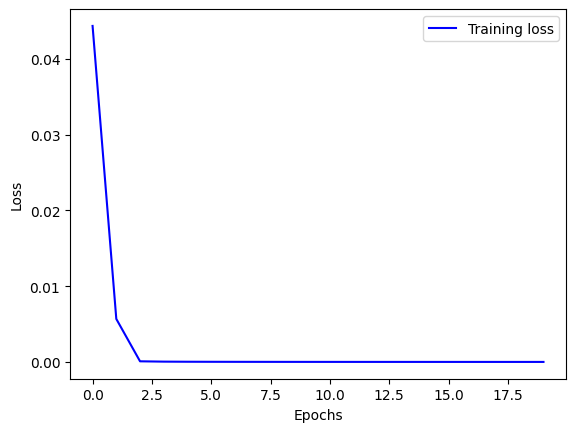

In [83]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Тестирование

In [84]:
Y_pred = model.predict(X_test)

2501/2501 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [87]:
plot_preds(Y_pred[:, 0], 'cnn')

Без масштабирования окон приемлемо, ложных срабатывния нет, все отказы обнаружил, но некоторые с большим запаздыванием.

In [ ]:
metrics.loc['cnn', :] = calc_metrics(X_states, Y_pred[:,0])
metrics

,roc_auc,f1,MCC
tsfresh_cb,0.56036,0.200074,0.23308
cnn,0.616004,0.375,0.467742


### <a id='toc4_2_2_'></a>[CNN на смещенном паттерне](#toc0_)

По графику работы CNN видно, что модель пропускает те отказы, которые по уровню сильно выше или ниже обучающего отказа. Проверим это, протестировав модель на смещенных отказах.

In [99]:
X_biased = X.copy()

Диапазон обучающего отказа 85 - 90

Должен исчезнуть

In [100]:
X_biased.loc['2022-04-16 00:00:00':'2022-04-25 06:40:00',:] = X_biased.loc['2022-04-16 00:00:00':'2022-04-25 06:40:00',:] + 8

Должен обнаружиться

In [101]:
X_biased.loc['2022-08-11 00:00:00':'2022-08-17 00:40:00',:] = X_biased.loc['2022-08-11 00:00:00':'2022-08-17 00:40:00',:] - 6

Должен обнаружиться

In [102]:
X_biased.loc['2023-09-16 00:00:00':'2023-09-22 05:10:00',:] = X_biased.loc['2023-09-16 00:00:00':'2023-09-22 05:10:00',:] + 7

In [103]:
X_biased_scaled, scaler = scale_data(X_biased, train_periods, failurs)

In [104]:
index_cur_time_test, X_test_biased = create_test_sample(X_biased_scaled, offline_periods, win_size=win_size)

In [105]:
Y_pred = model.predict(X_test_biased)

2501/2501 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


Рисуем результат

In [ ]:
fig = make_subplots(rows=2, cols=1, vertical_spacing=0.1,
                    specs=[[{"secondary_y": True}],[{"secondary_y": True}]], 
                    shared_xaxes = True)

for col in X_biased.columns:
        fig.add_trace(go.Scattergl( x = X_biased.index,
                                    y = X_biased[col].values,
                                    mode = 'lines',
                                    name = col,
                                    showlegend =True),
                                    row = 1, col = 1)

fig.add_trace(go.Scattergl(x = index_cur_time_test,
                                    y = Y_pred[:, 0]*100,
                                    mode = 'lines', name = 'probability_failure', showlegend =True),
                                    row = 2, col = 1)

fig.add_trace(go.Bar(x = X_states.index,
                             y = X_states['offline'].values,
                             name = 'offline',
                             showlegend =True,
                             opacity=0.2,
                             hovertemplate='%{y:.2f}',
                             width=100,
                             marker_color='black',
                             marker_line_color='black'
                            ),
                      secondary_y=True,
                      row = 1, col = 1)

fig.add_trace(go.Bar(x = X_states.index,
                             y = X_states['green_failurs'].values,
                             name = 'green_failurs',
                             showlegend =True,
                             opacity=0.2,
                             hovertemplate='%{y:.2f}',
                             width=100,
                             marker_color='red',
                             marker_line_color='red'
                            ),
                      secondary_y=True,
                      row = 1, col = 1)

fig.add_trace(go.Bar(x = X_states.index,
                             y = X_states['Normal'].values,
                             name = 'Normal',
                             showlegend =True,
                             opacity=0.2,
                             hovertemplate='%{y:.2f}',
                             width=100,
                             marker_color='green',
                             marker_line_color='green'
                            ),
                      secondary_y=True,
                      row = 1, col = 1)

fig['layout']['showlegend'] = True
fig['layout']['title'] = 'cnn_biased'
fig.update_layout(hovermode = "x unified")


plotly.offline.plot(fig, filename = "graphs/cnn_biased.html",  show_link=False, auto_open=False)

'graphs/cnn_biased.html'

Все как и предполагалось. Теперь масштабируем каждое окно.

### <a id='toc4_2_3_'></a>[CNN с масштабированием каждого окна](#toc0_)

4 Масштабирование каждого окна

In [107]:
def scale_window(X):
	win_mean = np.mean(np.mean(X,axis=1),axis=1)
	win_mean = np.tile(win_mean,(X.shape[2],1)).transpose((1,0))

	win_mean = np.tile(win_mean,(X.shape[1],1,1)).transpose((1,0,2))
	X_scaled = X - win_mean
	return X_scaled

In [108]:
X_train_scaled = scale_window(X_train)

In [109]:
epochs = 20
batch_size = 32

model = make_model(input_shape=X_train.shape[1:])

model.compile(
    optimizer= tf.keras.optimizers.Nadam(learning_rate=0.001),
    loss= 'BinaryCrossentropy',
    metrics=['accuracy'])

callbacks=[ModelCheckpoint("CNN_win_callbacks/best_model.keras", monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 1),
          EarlyStopping(monitor="val_loss", patience=40, verbose=1),
          DWELL(model = model, factor=0.985, verbose=True)]

history = model.fit(
    X_train_scaled,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.3,
    shuffle = False,
    class_weight=class_weights,
    verbose=1
    )

Epoch 1/20
273/281 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9797 - loss: 0.4242
Epoch 1: val_loss improved from inf to 0.01279, saving model to CNN_win_callbacks/best_model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9801 - loss: 0.4137 - val_accuracy: 0.9995 - val_loss: 0.0128
Epoch 2/20
277/281 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0015
Epoch 2: val_loss improved from 0.01279 to 0.00018, saving model to CNN_win_callbacks/best_model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 1.7995e-04
Epoch 3/20
280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3689e-04
Epoch 3: val_loss improved from 0.00018 to 0.00005, saving model to CNN_win_callbacks/best_model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 2.3663e-04 - val_accuracy: 1.0000 - val_loss: 4.7793e-05
Epoch 4/20
278/281 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000

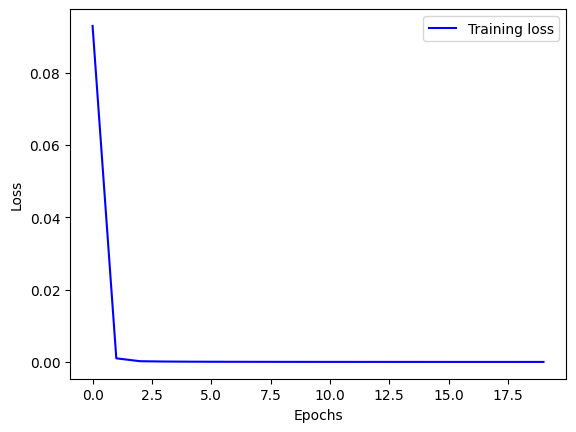

In [110]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [111]:
X_test_scaled = scale_window(X_test)

In [112]:
Y_pred = model.predict(X_test_scaled)

2501/2501 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


Рисуем результат

In [113]:
plot_preds(Y_pred[:, 0], 'cnn_win')

In [ ]:
metrics.loc['cnn_win', :] = calc_metrics(X_states, Y_pred[:,0])
metrics

,roc_auc,f1,MCC
tsfresh_cb,0.56036,0.200074,0.23308
cnn,0.616004,0.375,0.467742
cnn_win,0.880621,0.864438,0.868353


## <a id='toc4_3_'></a>[Vanilla Transformer](#toc0_)

### <a id='toc4_3_1_'></a>[С масштабированием всей выборки](#toc0_)

In [115]:
weights

array([0.52693921, 9.78015267])

In [116]:
weights_tensor = torch.tensor(weights.astype('float32'))

In [117]:
# Гиперпараметры
input_dim = 12  # Размерность каждого временного шага
num_classes = 2  # Количество классов для классификации
seq_length = 48  # Длина временного ряда
batch_size = 32
num_epochs = 20
learning_rate = 0.001
num_heads = 4
num_layers = 2
hidden_dim = 128
dropout = 0.1

In [118]:
# Преобразуем данные в PyTorch тензоры
X_tensor = torch.tensor(X_train.astype('float32'))
y_tensor = torch.tensor(Y_train[:,0].astype('int64'))

In [119]:
# Разделим данные на обучающую и тестовую выборки
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          #shuffle=False
                          )

In [120]:
# Определим модель Transformer для классификации
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_heads, num_layers, dropout):
        super(TransformerClassifier, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.num_classes = num_classes

        # Входной линейный слой для приведения входных данных к скрытой размерности
        self.embedding = nn.Linear(input_dim, hidden_dim)

        # Трансформер Encoder
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=num_heads,
                dim_feedforward=hidden_dim,
                # dropout=dropout
            ),
            num_layers=num_layers
        )

        # Линейный слой для классификации
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Применяем линейное преобразование к данным
        x = self.embedding(x)

        # Применяем трансформер
        # Для PyTorch nn.Transformer ожидает вход размером (seq_len, batch_size, input_dim)
        x = x.permute(1, 0, 2)  # меняем размерность на (seq_len, batch_size, hidden_dim)
        x = self.transformer(x)

        # Применяем усреднение по времени (среднее по всем временным шагам)
        x = x.mean(dim=0)

        # Прогоняем через линейный слой для классификации
        x = self.fc(x)
        return x

In [121]:
# Инициализируем модель, функцию потерь и оптимизатор
model = TransformerClassifier(input_dim, hidden_dim, num_classes, num_heads, num_layers, dropout)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [122]:
# Обучение модели
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        optimizer.zero_grad()

        # Прямой проход
        output = model(data)

        # Вычисление потерь
        loss = criterion(output, target)
        loss.backward()

        # Обновление весов
        optimizer.step()

        running_loss += loss.item()

        # Оценка точности
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

Epoch 1/20, Loss: 0.0059, Accuracy: 99.79%
Epoch 2/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 3/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 4/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 5/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 6/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 7/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 8/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 9/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 10/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 11/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 12/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 13/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 14/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 15/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 16/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 17/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 18/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 19/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 20/20, Loss: 0.0000, Accuracy: 100.00%


In [123]:
# Оценка на тестовых данных
X_test_tensor = torch.tensor(X_test.astype('float32'))

In [124]:
test_indexes = np.array([i for i in range(X_test.shape[0])])

In [125]:
test_dataset = TensorDataset(X_test_tensor, torch.tensor(test_indexes))
test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                         #shuffle=False
                         )

In [126]:
model.eval()
predictions = torch.tensor(np.array([]))
pred_proba_0 = torch.tensor(np.array([]))
pred_proba_1 = torch.tensor(np.array([]))
with torch.no_grad():
    for data, indexes in test_loader:
        output = model(data)
        _, predicted = torch.max(output, 1)
        predictions = torch.cat((predictions, predicted))
        pred_proba_0 = torch.cat((pred_proba_0, output[:,0]))
        pred_proba_1 = torch.cat((pred_proba_1, output[:,1]))

In [127]:
preds = np.array(predictions)

In [128]:
np.mean(preds)

0.025086872828179296

In [129]:
metrics.loc['tr', :] = calc_metrics(X_states, preds)
metrics

,roc_auc,f1,MCC
tsfresh_cb,0.56036,0.200074,0.23308
cnn,0.616004,0.375,0.467742
cnn_win,0.880621,0.864438,0.868353
tr,0.664349,0.494766,0.565771


In [130]:
softmax = nn.Softmax()

In [131]:
probabilities = softmax(torch.tensor(np.column_stack((np.array(pred_proba_0), np.array(pred_proba_1)))))

In [132]:
Y_pred = np.array(probabilities)[:,1]

In [ ]:
plot_preds(Y_pred, 'tr')

### <a id='toc4_3_2_'></a>[С масштабированием каждого окна](#toc0_)

In [134]:
# Преобразуем данные в PyTorch тензоры
X_tensor = torch.tensor(X_train_scaled.astype('float32'))
y_tensor = torch.tensor(Y_train[:,0].astype('int64'))

In [135]:
# Разделим данные на обучающую и тестовую выборки
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          # shuffle=True
                          )

In [136]:
# Определим модель Transformer для классификации
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_heads, num_layers, dropout):
        super(TransformerClassifier, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.num_classes = num_classes

        # Входной линейный слой для приведения входных данных к скрытой размерности
        self.embedding = nn.Linear(input_dim, hidden_dim)

        # Трансформер Encoder
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=num_heads,
                dim_feedforward=hidden_dim,
                # dropout=dropout
            ),
            num_layers=num_layers
        )

        # Линейный слой для классификации
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Применяем линейное преобразование к данным
        x = self.embedding(x)

        # Применяем трансформер
        # Для PyTorch nn.Transformer ожидает вход размером (seq_len, batch_size, input_dim)
        x = x.permute(1, 0, 2)  # меняем размерность на (seq_len, batch_size, hidden_dim)
        x = self.transformer(x)

        # Применяем усреднение по времени (среднее по всем временным шагам)
        x = x.mean(dim=0)

        # Прогоняем через линейный слой для классификации
        x = self.fc(x)
        return x

In [137]:
# Инициализируем модель, функцию потерь и оптимизатор
model = TransformerClassifier(input_dim, hidden_dim, num_classes, num_heads, num_layers, dropout)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [138]:
# Обучение модели
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        optimizer.zero_grad()

        # Прямой проход
        output = model(data)

        # Вычисление потерь
        loss = criterion(output, target)
        loss.backward()

        # Обновление весов
        optimizer.step()

        running_loss += loss.item()

        # Оценка точности
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

Epoch 1/20, Loss: 0.0101, Accuracy: 99.63%
Epoch 2/20, Loss: 0.0001, Accuracy: 100.00%
Epoch 3/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 4/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 5/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 6/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 7/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 8/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 9/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 10/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 11/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 12/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 13/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 14/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 15/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 16/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 17/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 18/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 19/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 20/20, Loss: 0.0000, Accuracy: 100.00%


In [139]:
# Оценка на тестовых данных
X_test_tensor = torch.tensor(X_test_scaled.astype('float32'))

In [140]:
test_indexes = np.array([i for i in range(X_test_scaled.shape[0])])

In [141]:
test_dataset = TensorDataset(X_test_tensor, torch.tensor(test_indexes))
test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                         # shuffle=False
                         )

In [142]:
model.eval()
predictions = torch.tensor(np.array([]))
pred_proba_0 = torch.tensor(np.array([]))
pred_proba_1 = torch.tensor(np.array([]))
with torch.no_grad():
    for data, indexes in test_loader:
        output = model(data)
        _, predicted = torch.max(output, 1)
        predictions = torch.cat((predictions, predicted))
        pred_proba_0 = torch.cat((pred_proba_0, output[:,0]))
        pred_proba_1 = torch.cat((pred_proba_1, output[:,1]))

In [143]:
preds = np.array(predictions)

In [144]:
np.mean(preds)

0.045311367215819603

In [145]:
metrics.loc['tr_win', :] = calc_metrics(X_states, preds)
metrics

,roc_auc,f1,MCC
tsfresh_cb,0.56036,0.200074,0.23308
cnn,0.616004,0.375,0.467742
cnn_win,0.880621,0.864438,0.868353
tr,0.664349,0.494766,0.565771
tr_win,0.98331,0.983027,0.982512


Метрики улетели в космос. Не случайно у меня диплом по космическим двигателям.

In [146]:
softmax = nn.Softmax()

In [147]:
probabilities = softmax(torch.tensor(np.column_stack((np.array(pred_proba_0), np.array(pred_proba_1)))))

In [148]:
Y_pred = np.array(probabilities)[:,1]

In [ ]:
plot_preds(Y_pred, 'tr_win')

## <a id='toc4_4_'></a>[CNN + Transformer](#toc0_)

### <a id='toc4_4_1_'></a>[С масштабированием всей выборки](#toc0_)

In [150]:
weights

array([0.52693921, 9.78015267])

In [152]:
# Преобразуем данные в PyTorch тензоры
X_tensor = torch.tensor(X_train.astype('float32'))
y_tensor = torch.tensor(Y_train[:,0].astype('int64'))

In [153]:
# Гиперпараметры
input_dim = 12  # Размерность каждого временного шага
num_classes = 2  # Количество классов для классификации
seq_length = 48  # Длина временного ряда
batch_size = 32
num_epochs = 10
learning_rate = 0.001

In [154]:
# Разделим данные на обучающую и тестовую выборки
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          #shuffle=False
                          )

In [155]:
# Определим модель Transformer для классификации
class TimesNet(nn.Module):
    def __init__(self, input_dim, num_classes, seq_length):
        super(TimesNet, self).__init__()

        self.input_dim = input_dim
        self.num_classes = num_classes
        self.seq_length = seq_length

        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)

        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=128, 
            nhead=4, 
            dim_feedforward=512, 
            dropout=0.1)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, 
            num_layers=4)

        # 3. Полносвязные слои для классификации
        self.fc1 = nn.Linear(128 * seq_length, 256)
        self.fc2 = nn.Linear(256, self.num_classes)

    def forward(self, x):
        # Применяем свертки
        x = x.permute(0, 2, 1)  # Изменяем форму с (batch, channels, time) на (batch, time, channels)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x)) # -> (32, 48, 128)
        
        # Применяем трансформер
        x = x.permute(2, 0, 1) # (channels, batch, time) = (128, 32, 48) () ## (time, batch, channels)
        x = self.transformer(x) # d_model=128 - кодирует временные метки
        
        # Преобразуем в формат для полносвязных слоёв
        x = x.permute(1, 0, 2)  # (batch, time, channels)
        x = x.flatten(1, -1)  # Flatten: (batch, time * channels)
        
        # Полносвязные слои
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [156]:
# Инициализируем модель, функцию потерь и оптимизатор
model = TimesNet(input_dim, num_classes, seq_length)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [157]:
# Обучение модели
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        optimizer.zero_grad()

        # Прямой проход
        output = model(data)

        # Вычисление потерь
        loss = criterion(output, target)
        loss.backward()

        # Обновление весов
        optimizer.step()

        running_loss += loss.item()

        # Оценка точности
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

Epoch 1/10, Loss: 0.0430, Accuracy: 99.28%
Epoch 2/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 3/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 4/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 5/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 6/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 7/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 8/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 9/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 10/10, Loss: 0.0000, Accuracy: 100.00%


In [158]:
# Оценка на тестовых данных
X_test_tensor = torch.tensor(X_test.astype('float32'))

In [159]:
test_indexes = np.array([i for i in range(X_test.shape[0])])

In [160]:
test_dataset = TensorDataset(X_test_tensor, torch.tensor(test_indexes))
test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                         #shuffle=False
                         )

In [161]:
model.eval()
predictions = torch.tensor(np.array([]))
pred_proba_0 = torch.tensor(np.array([]))
pred_proba_1 = torch.tensor(np.array([]))
with torch.no_grad():
    for data, indexes in test_loader:
        output = model(data)
        _, predicted = torch.max(output, 1)
        predictions = torch.cat((predictions, predicted))
        pred_proba_0 = torch.cat((pred_proba_0, output[:,0]))
        pred_proba_1 = torch.cat((pred_proba_1, output[:,1]))

In [162]:
preds = np.array(predictions)

In [163]:
np.mean(preds)

0.013337166570835729

In [164]:
metrics.loc['cnn_tr', :] = calc_metrics(X_states, preds)
metrics

,roc_auc,f1,MCC
tsfresh_cb,0.56036,0.200074,0.23308
cnn,0.616004,0.375,0.467742
cnn_win,0.880621,0.864438,0.868353
tr,0.664349,0.494766,0.565771
tr_win,0.98331,0.983027,0.982512
cnn_tr,0.546824,0.171259,0.300617


In [165]:
softmax = nn.Softmax()

In [166]:
probabilities = softmax(torch.tensor(np.column_stack((np.array(pred_proba_0), np.array(pred_proba_1)))))

In [167]:
Y_pred = np.array(probabilities)[:,1]

In [ ]:
plot_preds(Y_pred, 'cnn_tr')

### <a id='toc4_4_2_'></a>[CNN + Transformer с масштабированием каждого окна](#toc0_)

In [169]:
# Преобразуем данные в PyTorch тензоры
X_tensor = torch.tensor(X_train_scaled.astype('float32'))
y_tensor = torch.tensor(Y_train[:,0].astype('int64'))

In [170]:
# Разделим данные на обучающую и тестовую выборки
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          #shuffle=False
                          )

In [171]:
# Инициализируем модель, функцию потерь и оптимизатор
model = TimesNet(input_dim, num_classes, seq_length)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [172]:
# Обучение модели
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        optimizer.zero_grad()

        # Прямой проход
        output = model(data)

        # Вычисление потерь
        loss = criterion(output, target)
        loss.backward()

        # Обновление весов
        optimizer.step()

        running_loss += loss.item()

        # Оценка точности
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

Epoch 1/10, Loss: 0.0625, Accuracy: 98.53%
Epoch 2/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 3/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 4/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 5/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 6/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 7/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 8/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 9/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 10/10, Loss: 0.0000, Accuracy: 100.00%


In [173]:
# Оценка на тестовых данных
X_test_tensor = torch.tensor(X_test_scaled.astype('float32'))

In [174]:
test_indexes = np.array([i for i in range(X_test.shape[0])])

In [175]:
test_dataset = TensorDataset(X_test_tensor, torch.tensor(test_indexes))
test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                         #shuffle=False
                         )

In [176]:
model.eval()
predictions = torch.tensor(np.array([]))
pred_proba_0 = torch.tensor(np.array([]))
pred_proba_1 = torch.tensor(np.array([]))
with torch.no_grad():
    for data, indexes in test_loader:
        output = model(data)
        _, predicted = torch.max(output, 1)
        predictions = torch.cat((predictions, predicted))
        pred_proba_0 = torch.cat((pred_proba_0, output[:,0]))
        pred_proba_1 = torch.cat((pred_proba_1, output[:,1]))

In [177]:
preds = np.array(predictions)

In [178]:
np.mean(preds)

0.05772355691107722

In [179]:
metrics.loc['cnn_tr_win', :] = calc_metrics(X_states, preds)
metrics

,roc_auc,f1,MCC
tsfresh_cb,0.56036,0.200074,0.23308
cnn,0.616004,0.375,0.467742
cnn_win,0.880621,0.864438,0.868353
tr,0.664349,0.494766,0.565771
tr_win,0.98331,0.983027,0.982512
cnn_tr,0.546824,0.171259,0.300617
cnn_tr_win,0.991766,0.988816,0.988385


In [180]:
softmax = nn.Softmax()

In [181]:
probabilities = softmax(torch.tensor(np.column_stack((np.array(pred_proba_0), np.array(pred_proba_1)))))

In [182]:
Y_pred = np.array(probabilities)[:,1]

In [ ]:
plot_preds(Y_pred, 'cnn_tr_win')

## <a id='toc4_5_'></a>[Informer](#toc0_)

### <a id='toc4_5_1_'></a>[С масштабированием всей выборки](#toc0_)

In [184]:
import math

In [185]:
weights

array([0.52693921, 9.78015267])

In [187]:
# Преобразуем данные в PyTorch тензоры
X_tensor = torch.tensor(X_train.astype('float32'))
y_tensor = torch.tensor(Y_train[:,0].astype('int64'))

In [188]:
# Разделим данные на обучающую и тестовую выборки
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          #shuffle=False
                          )

In [189]:
# Определение механизма внимания с линейной сложностью (Probabilistic Linear Time Attention)
class ProbSparseAttention(nn.Module):
    def __init__(self, dim, num_heads, dropout=0.1, k=20):
        super(ProbSparseAttention, self).__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.k = k  # Число ближайших соседей для внимания
        self.dropout = dropout

        # Определяем слои для проекции запросов (Q), ключей (K) и значений (V)
        self.query_proj = nn.Linear(dim, dim)
        self.key_proj = nn.Linear(dim, dim)
        self.value_proj = nn.Linear(dim, dim)
        self.out_proj = nn.Linear(dim, dim)

        self.dropout_layer = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, mask=None):
        batch_size, seq_len, _ = queries.size()
        num_heads = self.num_heads
        head_dim = self.dim // num_heads

        # Проектируем Q, K, V
        Q = self.query_proj(queries).view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)
        K = self.key_proj(keys).view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)
        V = self.value_proj(values).view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)
        
        # Считаем вероятностное внимание
        attn_weights = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(head_dim)

        if mask is not None:
            attn_weights = attn_weights.masked_fill(mask == 0, float('-inf'))

        # Применяем attention и получаем результат
        attn = torch.softmax(attn_weights, dim=-1)
        attn = self.dropout_layer(attn)

        output = torch.matmul(attn, V).transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        output = self.out_proj(output)

        return output

In [190]:
# Определение энкодера
class InformerEncoderLayer(nn.Module):
    def __init__(self, dim, num_heads, dropout=0.1, k=20):
        super(InformerEncoderLayer, self).__init__()
        self.attn = ProbSparseAttention(dim, num_heads, dropout, k)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Linear(dim * 4, dim)
        )
        self.layer_norm1 = nn.LayerNorm(dim)
        self.layer_norm2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Механизм внимания
        attn_out = self.attn(x, x, x, mask)
        x = self.layer_norm1(x + self.dropout(attn_out))

        # Feed Forward слой
        ffn_out = self.ffn(x)
        x = self.layer_norm2(x + self.dropout(ffn_out))

        return x

In [191]:
# Определение модели Informer для классификации
class InformerForClassification(nn.Module):
    def __init__(self, input_size, num_classes, dim, num_heads, num_layers, dropout=0.1, k=20):
        super(InformerForClassification, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        self.dim = dim
# Входной слой для проекции
        self.input_proj = nn.Linear(input_size, dim)

        # Энкодер Informer
        self.encoder_layers = nn.ModuleList([
            InformerEncoderLayer(dim, num_heads, dropout, k) for _ in range(num_layers)
        ])

        # Выходной слой для классификации
        self.classifier = nn.Linear(dim, num_classes)

    def forward(self, x, mask=None):
        # Преобразуем входные данные через проекцию
        x = self.input_proj(x)

        # Пропускаем через энкодер
        for layer in self.encoder_layers:
            x = layer(x, mask)

        # Используем только последний временной шаг для классификации
        x = x[:, -1, :]  # Берем представление последнего временного шага

        # Прогоняем через классификатор
        output = self.classifier(x)
        return output

In [192]:
# Параметры модели
input_size = 12  # Например, 10 признаков на каждом временном шаге
num_classes = 2  # Количество классов для классификации
dim = 64  # Размерность модели
num_heads = 4  # Количество голов в многоголовом внимании
num_layers = 4  # Количество слоев в энкодере
dropout = 0.1  # Дроп-аут для регуляризации
k = 20  # Число ближайших соседей в вероятностном механизме внимания
learning_rate = 0.001
epochs = 20

In [193]:
# Инициализируем модель, функцию потерь и оптимизатор
model = InformerForClassification(input_size, num_classes, dim, num_heads, num_layers, dropout, k)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [194]:
# Обучение модели
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        optimizer.zero_grad()

        # Прямой проход
        output = model(data)

        # Вычисление потерь
        loss = criterion(output, target)
        loss.backward()

        # Обновление весов
        optimizer.step()

        running_loss += loss.item()

        # Оценка точности
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

Epoch 1/20, Loss: 0.0153, Accuracy: 99.56%
Epoch 2/20, Loss: 0.0003, Accuracy: 100.00%
Epoch 3/20, Loss: 0.0001, Accuracy: 100.00%
Epoch 4/20, Loss: 0.0001, Accuracy: 100.00%
Epoch 5/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 6/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 7/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 8/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 9/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 10/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 11/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 12/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 13/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 14/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 15/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 16/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 17/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 18/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 19/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 20/20, Loss: 0.0000, Accuracy: 100.00%


In [195]:
# Оценка на тестовых данных
X_test_tensor = torch.tensor(X_test.astype('float32'))

In [196]:
test_indexes = np.array([i for i in range(X_test.shape[0])])

In [197]:
test_dataset = TensorDataset(X_test_tensor, torch.tensor(test_indexes))
test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                         #shuffle=False
                         )

In [198]:
model.eval()
predictions = torch.tensor(np.array([]))
pred_proba_0 = torch.tensor(np.array([]))
pred_proba_1 = torch.tensor(np.array([]))
with torch.no_grad():
    for data, indexes in test_loader:
        output = model(data)
        _, predicted = torch.max(output, 1)
        predictions = torch.cat((predictions, predicted))
        pred_proba_0 = torch.cat((pred_proba_0, output[:,0]))
        pred_proba_1 = torch.cat((pred_proba_1, output[:,1]))

In [199]:
preds = np.array(predictions)

In [200]:
np.mean(preds)

0.02423689407764806

In [201]:
metrics.loc['informer', :] = calc_metrics(X_states, preds)
metrics

,roc_auc,f1,MCC
tsfresh_cb,0.56036,0.200074,0.23308
cnn,0.616004,0.375,0.467742
cnn_win,0.880621,0.864438,0.868353
tr,0.664349,0.494766,0.565771
tr_win,0.98331,0.983027,0.982512
cnn_tr,0.546824,0.171259,0.300617
cnn_tr_win,0.991766,0.988816,0.988385
informer,0.656421,0.475855,0.549699


In [202]:
softmax = nn.Softmax()

In [203]:
probabilities = softmax(torch.tensor(np.column_stack((np.array(pred_proba_0), np.array(pred_proba_1)))))

In [204]:
Y_pred = np.array(probabilities)[:,1]

In [ ]:
plot_preds(Y_pred, 'informer')

### <a id='toc4_5_2_'></a>[Informer с масштабированием каждого окна](#toc0_)

In [206]:
# Преобразуем данные в PyTorch тензоры
X_tensor = torch.tensor(X_train_scaled.astype('float32'))
y_tensor = torch.tensor(Y_train[:,0].astype('int64'))

In [207]:
# Разделим данные на обучающую и тестовую выборки
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          #shuffle=False
                          )

In [208]:
# Инициализируем модель, функцию потерь и оптимизатор
model = InformerForClassification(input_size, num_classes, dim, num_heads, num_layers, dropout, k)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [209]:
# Обучение модели
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        optimizer.zero_grad()

        # Прямой проход
        output = model(data)

        # Вычисление потерь
        loss = criterion(output, target)
        loss.backward()

        # Обновление весов
        optimizer.step()

        running_loss += loss.item()

        # Оценка точности
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

Epoch 1/10, Loss: 0.0174, Accuracy: 99.54%
Epoch 2/10, Loss: 0.0003, Accuracy: 100.00%
Epoch 3/10, Loss: 0.0002, Accuracy: 100.00%
Epoch 4/10, Loss: 0.0001, Accuracy: 100.00%
Epoch 5/10, Loss: 0.0001, Accuracy: 100.00%
Epoch 6/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 7/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 8/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 9/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 10/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 11/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 12/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 13/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 14/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 15/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 16/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 17/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 18/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 19/10, Loss: 0.0000, Accuracy: 100.00%
Epoch 20/10, Loss: 0.0000, Accuracy: 100.00%


In [210]:
# Оценка на тестовых данных
X_test_tensor = torch.tensor(X_test_scaled.astype('float32'))

In [211]:
test_indexes = np.array([i for i in range(X_test.shape[0])])

In [212]:
test_dataset = TensorDataset(X_test_tensor, torch.tensor(test_indexes))
test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                         #shuffle=False
                         )

In [213]:
model.eval()
predictions = torch.tensor(np.array([]))
pred_proba_0 = torch.tensor(np.array([]))
pred_proba_1 = torch.tensor(np.array([]))
with torch.no_grad():
    for data, indexes in test_loader:
        output = model(data)
        _, predicted = torch.max(output, 1)
        predictions = torch.cat((predictions, predicted))
        pred_proba_0 = torch.cat((pred_proba_0, output[:,0]))
        pred_proba_1 = torch.cat((pred_proba_1, output[:,1]))

In [214]:
preds = np.array(predictions)

In [215]:
np.mean(preds)

0.048023799405014875

In [216]:
metrics.loc['informer_win', :] = calc_metrics(X_states, preds)
metrics

,roc_auc,f1,MCC
tsfresh_cb,0.56036,0.200074,0.23308
cnn,0.616004,0.375,0.467742
cnn_win,0.880621,0.864438,0.868353
tr,0.664349,0.494766,0.565771
tr_win,0.98331,0.983027,0.982512
cnn_tr,0.546824,0.171259,0.300617
cnn_tr_win,0.991766,0.988816,0.988385
informer,0.656421,0.475855,0.549699
informer_win,0.986787,0.98661,0.986177


In [217]:
softmax = nn.Softmax()

In [218]:
probabilities = softmax(torch.tensor(np.column_stack((np.array(pred_proba_0), np.array(pred_proba_1)))))

In [219]:
Y_pred = np.array(probabilities)[:,1]

In [ ]:
plot_preds(Y_pred, 'informer_win')

## <a id='toc4_6_'></a>[iTransformer](#toc0_)

### <a id='toc4_6_1_'></a>[С масштабированием всей выборки](#toc0_)

In [221]:
# Гиперпараметры
input_dim = 12  # Размерность каждого временного шага
num_classes = 2  # Количество классов для классификации
seq_length = 48  # Длина временного ряда
batch_size = 32
num_epochs = 20
learning_rate = 0.001
num_heads = 4
num_layers = 2
hidden_dim = 128
dropout = 0.1

In [222]:
# Преобразуем данные в PyTorch тензоры
X_tensor = torch.tensor(X_train.astype('float32'))
y_tensor = torch.tensor(Y_train[:,0].astype('int64'))

In [223]:
# Разделим данные на обучающую и тестовую выборки
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          #shuffle=False
                          )

In [224]:
# Определим модель Transformer для классификации
class iTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_heads, num_layers, dropout):
        super(iTransformer, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.num_classes = num_classes

        # Входной линейный слой для приведения входных данных к скрытой размерности
        self.embedding = nn.Linear(48, 128)

        # Трансформер Encoder
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=128,
                nhead=4,
                dim_feedforward=128,
                # dropout=dropout
            ),
            num_layers=2
        )

        # Линейный слой для классификации
        self.fc1 = nn.Linear(12 * 128, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1) # -> (32, 12, 48)
        # Применяем линейное преобразование к данным
        x = self.embedding(x) # -> (32, 12, 128)

        # Применяем трансформер
        # Для PyTorch nn.Transformer ожидает вход размером (seq_len, batch_size, input_dim)
        x = x.permute(1, 0, 2)  # меняем размерность на (seq_len, batch_size, hidden_dim)
        x = self.transformer(x)

        # Применяем усреднение по времени (среднее по всем временным шагам)
        x = x.permute(1, 0, 2)
        x = x.flatten(1, -1)

        # Прогоняем через линейный слой для классификации
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [225]:
# Инициализируем модель, функцию потерь и оптимизатор
model = iTransformer(input_dim, hidden_dim, num_classes, num_heads, num_layers, dropout)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [226]:
# Обучение модели
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        optimizer.zero_grad()

        # Прямой проход
        output = model(data)

        # Вычисление потерь
        loss = criterion(output, target)
        loss.backward()

        # Обновление весов
        optimizer.step()

        running_loss += loss.item()

        # Оценка точности
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

Epoch 1/20, Loss: 0.0409, Accuracy: 98.65%
Epoch 2/20, Loss: 0.0001, Accuracy: 100.00%
Epoch 3/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 4/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 5/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 6/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 7/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 8/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 9/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 10/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 11/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 12/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 13/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 14/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 15/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 16/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 17/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 18/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 19/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 20/20, Loss: 0.0000, Accuracy: 100.00%


In [227]:
# Оценка на тестовых данных
X_test_tensor = torch.tensor(X_test.astype('float32'))

In [228]:
test_indexes = np.array([i for i in range(X_test.shape[0])])

In [229]:
test_dataset = TensorDataset(X_test_tensor, torch.tensor(test_indexes))
test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                         #shuffle=False
                         )

In [230]:
model.eval()
predictions = torch.tensor(np.array([]))
pred_proba_0 = torch.tensor(np.array([]))
pred_proba_1 = torch.tensor(np.array([]))
with torch.no_grad():
    for data, indexes in test_loader:
        output = model(data)
        _, predicted = torch.max(output, 1)
        predictions = torch.cat((predictions, predicted))
        pred_proba_0 = torch.cat((pred_proba_0, output[:,0]))
        pred_proba_1 = torch.cat((pred_proba_1, output[:,1]))

In [231]:
preds = np.array(predictions)

In [232]:
np.mean(preds)

0.037224069398265044

In [233]:
metrics.loc['itr', :] = calc_metrics(X_states, preds)
metrics

,roc_auc,f1,MCC
tsfresh_cb,0.56036,0.200074,0.23308
cnn,0.616004,0.375,0.467742
cnn_win,0.880621,0.864438,0.868353
tr,0.664349,0.494766,0.565771
tr_win,0.98331,0.983027,0.982512
cnn_tr,0.546824,0.171259,0.300617
cnn_tr_win,0.991766,0.988816,0.988385
informer,0.656421,0.475855,0.549699
informer_win,0.986787,0.98661,0.986177
itr,0.696337,0.55159,0.592896


In [234]:
softmax = nn.Softmax()

In [235]:
probabilities = softmax(torch.tensor(np.column_stack((np.array(pred_proba_0), np.array(pred_proba_1)))))

In [236]:
Y_pred = np.array(probabilities)[:,1]

In [ ]:
plot_preds(Y_pred, 'itr')

### <a id='toc4_6_2_'></a>[С масштабированием каждого окна](#toc0_)

In [238]:
# Преобразуем данные в PyTorch тензоры
X_tensor = torch.tensor(X_train_scaled.astype('float32'))
y_tensor = torch.tensor(Y_train[:,0].astype('int64'))

In [239]:
# Разделим данные на обучающую и тестовую выборки
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          # shuffle=True
                          )

In [240]:
# Инициализируем модель, функцию потерь и оптимизатор
model = iTransformer(input_dim, hidden_dim, num_classes, num_heads, num_layers, dropout)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [241]:
# Обучение модели
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        optimizer.zero_grad()

        # Прямой проход
        output = model(data)

        # Вычисление потерь
        loss = criterion(output, target)
        loss.backward()

        # Обновление весов
        optimizer.step()

        running_loss += loss.item()

        # Оценка точности
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

Epoch 1/20, Loss: 0.0227, Accuracy: 99.15%
Epoch 2/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 3/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 4/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 5/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 6/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 7/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 8/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 9/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 10/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 11/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 12/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 13/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 14/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 15/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 16/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 17/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 18/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 19/20, Loss: 0.0000, Accuracy: 100.00%
Epoch 20/20, Loss: 0.0000, Accuracy: 100.00%


In [242]:
# Оценка на тестовых данных
X_test_tensor = torch.tensor(X_test_scaled.astype('float32'))

In [243]:
test_indexes = np.array([i for i in range(X_test_scaled.shape[0])])

In [244]:
test_dataset = TensorDataset(X_test_tensor, torch.tensor(test_indexes))
test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                         # shuffle=False
                         )

In [245]:
model.eval()
predictions = torch.tensor(np.array([]))
pred_proba_0 = torch.tensor(np.array([]))
pred_proba_1 = torch.tensor(np.array([]))
with torch.no_grad():
    for data, indexes in test_loader:
        output = model(data)
        _, predicted = torch.max(output, 1)
        predictions = torch.cat((predictions, predicted))
        pred_proba_0 = torch.cat((pred_proba_0, output[:,0]))
        pred_proba_1 = torch.cat((pred_proba_1, output[:,1]))

In [246]:
preds = np.array(predictions)

In [247]:
np.mean(preds)

0.02819929501762456

In [248]:
metrics.loc['itr_win', :] = calc_metrics(X_states, preds)
metrics

,roc_auc,f1,MCC
tsfresh_cb,0.56036,0.200074,0.23308
cnn,0.616004,0.375,0.467742
cnn_win,0.880621,0.864438,0.868353
tr,0.664349,0.494766,0.565771
tr_win,0.98331,0.983027,0.982512
cnn_tr,0.546824,0.171259,0.300617
cnn_tr_win,0.991766,0.988816,0.988385
informer,0.656421,0.475855,0.549699
informer_win,0.986787,0.98661,0.986177
itr,0.696337,0.55159,0.592896


In [249]:
softmax = nn.Softmax()

In [250]:
probabilities = softmax(torch.tensor(np.column_stack((np.array(pred_proba_0), np.array(pred_proba_1)))))

In [251]:
Y_pred = np.array(probabilities)[:,1]

In [252]:
plot_preds(Y_pred, 'itr_win')

In [253]:
metrics

,roc_auc,f1,MCC
tsfresh_cb,0.56036,0.200074,0.23308
cnn,0.616004,0.375,0.467742
cnn_win,0.880621,0.864438,0.868353
tr,0.664349,0.494766,0.565771
tr_win,0.98331,0.983027,0.982512
cnn_tr,0.546824,0.171259,0.300617
cnn_tr_win,0.991766,0.988816,0.988385
informer,0.656421,0.475855,0.549699
informer_win,0.986787,0.98661,0.986177
itr,0.696337,0.55159,0.592896


In [254]:
metrics.to_csv('graphs/metrics.csv')

In [ ]:
metrics.sort_values(by='roc_auc', ascending=False)

,roc_auc,f1,MCC
cnn_tr_win,0.991766,0.988816,0.988385
informer_win,0.986787,0.98661,0.986177
tr_win,0.98331,0.983027,0.982512
cnn_win,0.880621,0.864438,0.868353
itr,0.696337,0.55159,0.592896
itr_win,0.693546,0.52671,0.550744
tr,0.664349,0.494766,0.565771
informer,0.656421,0.475855,0.549699
cnn,0.616004,0.375,0.467742
tsfresh_cb,0.56036,0.200074,0.23308


# <a id='toc5_'></a>[4 Выводы](#toc0_)

Решалась задача классификации многомерных временных рядов для поиска паттернов отказа технологического оборудования. 

В качестве данных используются показания с датчиков температуры подшипников компрессора за 2 года (2022-2023 гг) с дискретностью 10 мин. 

Для оценки качества использовалась метрика AUC-ROC. Также рассчитывались метрики f1 и MCC.

Было протестировано несколько алгоритмов на основе нейронных сетей, в качестве бейзлайна использовался CatBoost на признаках, сгенерированных с помощью библиотеки tsfresh:

1. Tsfresf + CatBoost 
2. CNN 
3. Vanilla Transformer 
4. CNN + Vanilla Transformer
5. Informer
6. iTransformer

В ходе тестирования было обнаружено, что на предсказания модели CNN сильно влияет величина значений тегов в рамках каждого окна (объекта), а не взаимосвязь между тегами. Модель пропускает отказы, где абсолютные значения тегов выше или ниже, чем на обучающем отказе. Тогда было протестировано масштабирование каждого окна отдельно, чтобы избавиться от уровня значений тегов.

Качество модели CNN с таким подходом сильно улучшилось, поэтому все алгоритмы были протестированы с применением такого масштабирования (помечены `win`) и без него. Результаты представлены в таблице.

In [11]:
metrics.sort_values(by='roc_auc', ascending=False)

,roc_auc,f1,MCC
cnn_tr_win,0.991766,0.988816,0.988385
informer_win,0.986787,0.986610,0.986177
tr_win,0.983310,0.983027,0.982512
cnn_win,0.880621,0.864438,0.868353
itr,0.696337,0.551590,0.592896
itr_win,0.693546,0.526710,0.550744
tr,0.664349,0.494766,0.565771
informer,0.656421,0.475855,0.549699
cnn,0.616004,0.375000,0.467742
tsfresh_cb,0.560360,0.200074,0.233080


Масштабирование каждого окна значительно улучшает результаты всех протестированных моделей, кроме iTransformer. Для нее результат почти не меняется. Худший результат показала модель на основе CNN + Vanilla Transformer. Она же показала наилучший результат с масштабированием каждого окна, ROC-AUC улетела в космос и составила 0,99 (не зря у меня диплом по космическим двигателям).